[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\kanna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                          clean_text sentiment  \
0                                          game hurt  Negative   
1  sexuality ’ grouping category makes different ...   Neutral   
2                            right dont care fuck em  Negative   
3                                    man love reddit  Positive   
4                           name nowhere near falcon  Positive   

                                          NER  
0                                      [game]  
1  [’ grouping category, definition grouping]  
2                                  [fuck, em]  
3                               [man, reddit]  
4                                    [falcon]  


C:\Users\kanna\AppData\Local\Temp\ipykernel_13128\826771744.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='viridis')


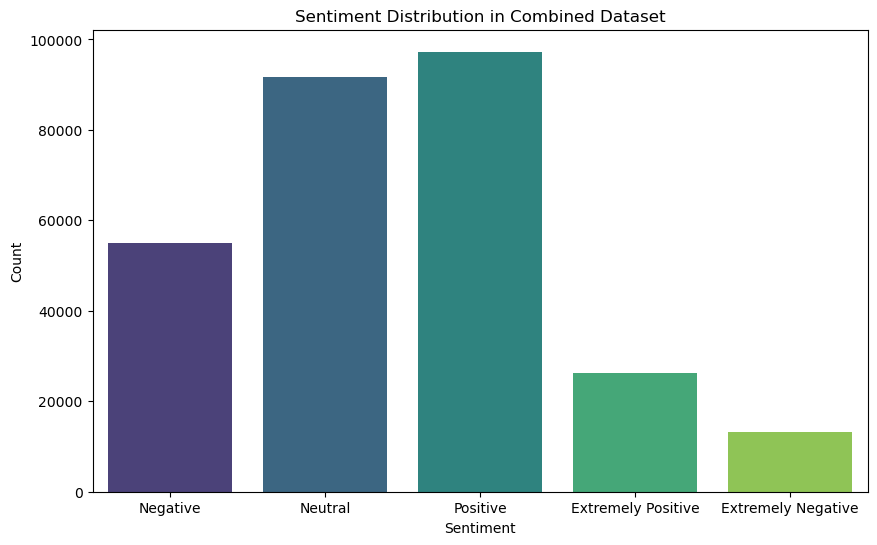

C:\Users\kanna\AppData\Local\Temp\ipykernel_13128\826771744.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ner_freq.values, y=ner_freq.index, palette='magma')


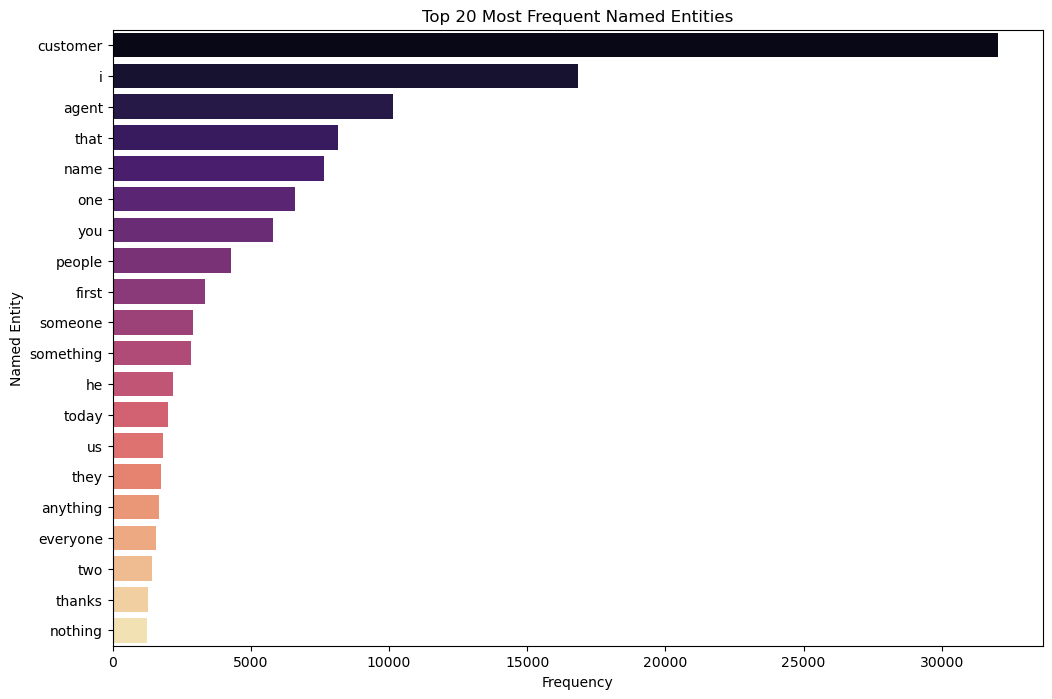

In [1]:
import pandas as pd
import json
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load datasets
def load_data():
    go_emotions = pd.read_csv("go_emotions_dataset.csv")
    reddit_data = pd.read_csv("reddit_text-davinci-002.csv")
    emotion_data = pd.read_csv("emotion-emotion_69k.csv")
    
    # Load JSON knowledge base
    with open("KB.json", "r") as f:
        kb_data = json.load(f)
    
    # Convert JSON into a structured DataFrame
    kb_df = pd.DataFrame(kb_data["intents"])  # Assuming 'intents' is the main key
    
    # Extract textual data from KB JSON
    if 'patterns' in kb_df.columns:
        kb_df = kb_df.explode('patterns')  # Handle lists inside JSON
        kb_df.rename(columns={'patterns': 'text'}, inplace=True)
    
    # Standardize column names
    if 'prompt' in reddit_data.columns:
        reddit_data.rename(columns={'prompt': 'text'}, inplace=True)
    
    if 'empathetic_dialogues' in emotion_data.columns:
        emotion_data.rename(columns={'empathetic_dialogues': 'text'}, inplace=True)
    
    return go_emotions, reddit_data, emotion_data, kb_df

# Preprocessing function (text cleaning)
def clean_text(text):
    text = str(text).lower().strip()  # Convert to lowercase and remove extra spaces
    text = re.sub(r'\s+', ' ', text)  # Normalize spaces
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Function to extract Named Entities AFTER preprocessing
def get_ner(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    if not entities:  # Fallback: Extract noun phrases if no named entities found
        entities = [chunk.text for chunk in doc.noun_chunks]
    return entities

# Function to get sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.5:
        return "Extremely Positive"
    elif analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity == 0:
        return "Neutral"
    elif analysis.sentiment.polarity < -0.5:
        return "Extremely Negative"
    else:
        return "Negative"

# Load NLP model
nlp = spacy.load("en_core_web_lg")

# Load data
go_emotions, reddit_data, emotion_data, kb_df = load_data()

# Apply text cleaning
for dataset in [go_emotions, reddit_data, emotion_data, kb_df]:
    dataset['clean_text'] = dataset['text'].apply(clean_text)

# Apply sentiment analysis
for dataset in [go_emotions, reddit_data, emotion_data, kb_df]:
    dataset['sentiment'] = dataset['clean_text'].apply(get_sentiment)

# Apply NER on preprocessed text
for dataset in [go_emotions, reddit_data, emotion_data, kb_df]:
    dataset['NER'] = dataset['clean_text'].apply(get_ner)

# Combine datasets
combined_data = pd.concat([
    go_emotions[['clean_text', 'sentiment', 'NER']],
    reddit_data[['clean_text', 'sentiment', 'NER']],
    emotion_data[['clean_text', 'sentiment', 'NER']],
    kb_df[['clean_text', 'sentiment', 'NER']]
])

# Save processed data
combined_data.to_csv("processed_chatbot_data.csv", index=False)

# Visualizations
def visualize_sentiment_distribution(data):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sentiment', data=data, palette='viridis')
    plt.title("Sentiment Distribution in Combined Dataset")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

def visualize_ner_frequency(data):
    ner_freq = data['NER'].explode().value_counts().head(20)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=ner_freq.values, y=ner_freq.index, palette='magma')
    plt.title("Top 20 Most Frequent Named Entities")
    plt.xlabel("Frequency")
    plt.ylabel("Named Entity")
    plt.show()

# Display sample output
print(combined_data.head())

# Generate visualizations
visualize_sentiment_distribution(combined_data)
visualize_ner_frequency(combined_data)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Converting text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features to prevent overfitting
X = vectorizer.fit_transform(combined_data['clean_text'])
y = combined_data['sentiment'] 

# Spliting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training and evaluating Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)
print("Naïve Bayes Performance:")
print(classification_report(y_test, nb_preds))
print("Accuracy:", accuracy_score(y_test, nb_preds))

# Training and evaluating SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("\nSVM Performance:")
print(classification_report(y_test, svm_preds))
print("Accuracy:", accuracy_score(y_test, svm_preds))


Naïve Bayes Performance:
                    precision    recall  f1-score   support

Extremely Negative       0.98      0.24      0.39      2732
Extremely Positive       0.97      0.33      0.49      5249
          Negative       0.78      0.65      0.71     10938
           Neutral       0.89      0.88      0.89     18232
          Positive       0.69      0.95      0.80     19577

          accuracy                           0.78     56728
         macro avg       0.86      0.61      0.66     56728
      weighted avg       0.81      0.78      0.76     56728

Accuracy: 0.7791919334367509

SVM Performance:
                    precision    recall  f1-score   support

Extremely Negative       0.92      0.92      0.92      2732
Extremely Positive       0.92      0.93      0.93      5249
          Negative       0.94      0.93      0.93     10938
           Neutral       0.97      0.98      0.97     18232
          Positive       0.96      0.95      0.95     19577

          accuracy     

In [3]:
import numpy as np
from collections import deque

# Store conversation for history tracking
conversation_history = deque(maxlen=3)

# Define chatbot responses
responses = {
    "Extremely Negative": [
        "I'm really sorry you're feeling this way. You’re not alone. Want to share more about what’s on your mind?",
        "That sounds really tough. I'm here to listen. What’s the hardest part for you right now?",
        "It’s okay to feel overwhelmed. Have you been able to talk to someone you trust about this?"
    ],
    "Negative": [
        "That must be really difficult. I am here for you. Would you like to share more about it?",
        "I hear you. You're not alone in this. Would it help to talk through how you are feeling?",
        "I can understand why that would be upsetting. Would you want comfort, advice, or just a listening ear?"
    ],
    "Neutral": [
        "I see, tell me more.",
        "That seems difficult. How has this been affecting you?",
        "Got it. What’s been on your mind the most lately?"
    ],
    "Positive": [
        "That is nice to hear! What has been making you feel this way?",
        "I love that! Tell me more about what has been going well.",
        "That sounds wonderful! How can you keep this positive energy going?"
    ],
    "Extremely Positive": [
        "Wow! What has been the highlight of your day?",
        "I love hearing this! What is something you are grateful for today?",
        "I am proud of you! Tell me what’s making you feel this way!"
    ]
}

# Define crisis keywords for immediate support
crisis_keywords = ["suicide", "die", "kill myself", "not want to live", "being alive is hard"]
affirmative_responses = ["yes", "i need help", "please give me resources"]

# Define support resources
support_resources = """
You are not alone. Here are some resources that will be of great help:
- Crisis Text Line: Text HOME to 741741 (Free, 24/7 support)
- National Suicide Prevention Lifeline: 988 (Available in the U.S.)
- If you are outside the U.S., visit https://findahelpline.com to find local support.
  Remember, your feelings are valid, and help is available.
"""

# Improved Chatbot Function with Crisis Handling
def chatbot():
    print("Mental Health Chatbot: Hi!! How are you feeling today? (Type 'exit' to end the chat)")

    while True:
        user_input = input("\nYou: ").strip().lower()
        if user_input == "exit":
            print("Chatbot: Take care dear, You are important, and I am always here if you need me.")
            break

        # Store user input for context tracking
        conversation_history.append(user_input)

        # **Crisis Detection**: Override response logic for distressing messages
        if any(keyword in user_input for keyword in crisis_keywords):
            print("Chatbot: This too shall pass, do not lost hope. You are not alone.If you need immediate support, please reach out to someone you trust or consider talking to a professional. Would you like some resources for help? (yes/no)")
            continue

        # If user asks for resources, provide them immediately
        if user_input in affirmative_responses:
            print(f"Chatbot: {support_resources}")
            continue

        # Context check
        if len(conversation_history) >= 2:
            last_message = conversation_history[-2]
            if "how is that good" in user_input or "what are you blabbering" in user_input:
                print("Chatbot: I am sorry if that did not make sense. I really want to understand how you are feeling.")
                continue

        # Preprocess and classify sentiment
        user_input_transformed = vectorizer.transform([user_input])
        sentiment = svm_model.predict(user_input_transformed)[0]
 
        # Response generation based on sentiment
        chatbot_reply = np.random.choice(responses[sentiment])
        print(f"Chatbot: {chatbot_reply}")

# Start chatbot
chatbot()


Mental Health Chatbot: Hi!! How are you feeling today? (Type 'exit' to end the chat)



You:  being alive is hard


Chatbot: This too shall pass, do not lost hope. You are not alone.If you need immediate support, please reach out to someone you trust or consider talking to a professional. Would you like some resources for help? (yes/no)



You:  yes


Chatbot: 
You are not alone. Here are some resources that will be of great help:
- Crisis Text Line: Text HOME to 741741 (Free, 24/7 support)
- National Suicide Prevention Lifeline: 988 (Available in the U.S.)
- If you are outside the U.S., visit https://findahelpline.com to find local support.
  Remember, your feelings are valid, and help is available.




You:  I had a good day today


Chatbot: Wow! What has been the highlight of your day?



You:  My exam went well


Chatbot: That seems difficult. How has this been affecting you?



You:  What are you blabbering?


Chatbot: I am sorry if that did not make sense. I really want to understand how you are feeling.



You:  It's alright.


Chatbot: I see, tell me more.



You:  How would you feel if your plant's flowers bloomed?


Chatbot: That seems difficult. How has this been affecting you?



You:  exit


Chatbot: Take care dear, You are important, and I am always here if you need me.
